### Step 1. Importing and preprocessing the dataset

In [238]:
import os # helps to read images froma a directory
import pandas as pd 
import numpy as np 
from tensorflow.keras.preprocessing.image import ImageDataGenerator # loading and processing images for Deep Learning
from tensorflow.keras.models import Sequential # to build a Deep Learning model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # layers for the Deep Learning model
from tensorflow.keras.optimizers import Adam # optimizer for training the model
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from sklearn.metrics import classification_report, confusion_matrix # evaluating the model
from sklearn.utils import class_weight

In [239]:
train_dir = 'data/chest_xray/train'
test_dir = 'data/chest_xray/test'
# num_classes = 2 # NORMAL, PNEUMONIA

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescaling pixel values from [0, 255] to [0, 1]
    rotation_range=10,      # Small rotations only (lungs should stay vertical)
    zoom_range=0.2,         # Zoom in slightly
    width_shift_range=0.1,  # Shift left/right
    height_shift_range=0.1, # Shift up/down
    horizontal_flip=True,   # Flip horizontally
    shear_range = 0.2,      # Slight tilt
    validation_split=0.2    # 80/20 train-val split
)

In [241]:
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    subset='training',
    batch_size=32,          # processing 32 images at a time
    seed=42,                # starting point for random operations
    class_mode='binary',    # binary classification (NORMAL vs PNEUMONIA)
    target_size=(150, 150)  # resizing images to 150x150 pixels
)

Found 4173 images belonging to 2 classes.


In [243]:
valid_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    subset='validation',
    batch_size=32,          
    seed=42,                
    class_mode='binary',    
    target_size=(150, 150)  
)

Found 1043 images belonging to 2 classes.


In [ ]:
test_generator = test_val_datagen.flow_from_directory(
    directory=test_dir,
    shuffle=False,
    batch_size=32,
    seed = 42,                   
    class_mode='binary',    
    target_size=(150, 150) 
)

Found 624 images belonging to 2 classes.


In [245]:
print("\nClass Indices:")
print("Train")
print(train_generator.class_indices)
print("Validation")
print(valid_generator.class_indices)
print("Test")
print(test_generator.class_indices)


Class Indices:
Train
{'NORMAL': 0, 'PNEUMONIA': 1}
Validation
{'NORMAL': 0, 'PNEUMONIA': 1}
Test
{'NORMAL': 0, 'PNEUMONIA': 1}


In [246]:
normal_count = 1341 * (1 - 0.2) 
pneumonia_count = 3875 * (1 - 0.2) 
total_train_samples = normal_count + pneumonia_count

train_labels = train_generator.classes 
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))
print(f"Calculated Class Weights: {class_weight_dict}")

Calculated Class Weights: {np.int32(0): np.float64(1.9445479962721341), np.int32(1): np.float64(0.6730645161290323)}


### Step 2. Building a CNN model (Convolution, ReLU, Pooling, Dense Layers)

In [ ]:
''' Building the CNN model
    Sequential model adds one layer after another in sequence, like a pipeline. Each layer transforms the data in some way.
    Conv2D layer applies convolution operation to extract features from images using filters/kernels.
    MaxPooling2D layer reduces the spatial dimensions (width and height) of the feature maps, retaining important information while reducing computational load.
    Flatten layer converts the 2D feature maps into a 1D vector, preparing it for the fully connected layers.
    Dropout layer randomly sets a fraction of input units to 0 during training to prevent overfitting.
    Dense layer is a fully connected layer where each neuron is connected to every neuron in the previous layer.
    The final Dense layer with a sigmoid activation function outputs a probability score between 0 and 1 for binary classification (NORMAL vs PNEUMONIA).
'''

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'), # finding the patterns in the images; 3 channels for RGB.
    MaxPooling2D((2, 2)), 
    Conv2D(64, (3, 3), activation='relu', padding='same'), # 64 filters to learn more complex features
    MaxPooling2D((2, 2)), 
    Conv2D(128, (3, 3), activation='relu'), # 128 filters for even more complex features
    MaxPooling2D((2, 2)),
    Flatten(), 
    Dropout(0.5),                   # prevent overfitting by randomly dropping 50% of the neurons during training
    Dense(512, activation='relu'),  # 512 neurons in this fully connected layer
    Dense(1, activation='sigmoid')  # 1 neuron for binary classification
])

c:\Repositories\computer-vision\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
""" Model compilation
    Adam optimizer is an efficient optimization algorithm that adjusts the learning rate during training.
    The output layer uses 'sigmoid' activation function suitable for binary classification tasks.
    Binary crossentropy is the loss function used for binary classification tasks."""

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 35, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

<!-- ![Output](assets/Output_1.png) -->

Output gave 3 columns: Layer (type), Output Shape and Param #. 
1. **Layer (type)** - is a type of neural network. This represents the specific mathematical operation performed on the data at this step.

    - **conv2d**: These are the "filters" scanning the X-ray for patterns like edges or cloudy areas.

    - **max_pooling2d**: This simplifies the image, reducing the resolution to keep only the most important features.

    - **dense**: This is the "brain" part of the model that takes all the patterns found and decides if they look like Pneumonia.

2. **Output Shape** - This tells you the dimensions of the data after it passes through the layer. E.g. In the image, (None, 148, 148, 32) means:

    - **None**: This is a placeholder for the Batch Size (how many images you process at once).

    - **148, 148**: The new height and width of the image (it gets smaller after convolutions).

    - **32**: The number of Filters (features) the layer is looking for.

3. **Param #** - This is the number of "weights" or "learned connections" the model is adjusting during training. 
- (First row) Param # (896): 
    - Filter size is a standard 3x3 kernel: **3 * 3 = 9**
    - Since X-rays are usually treated as RGB in these models, there are 3 channels (Red, Green, Blue): **9 * 3 = 27**)** 
    - Each filter has **1** bias weight: **27 + 1 = 28**
    - Number of Filters: This layer has **32 filters**.
    

        $$
        \text{Parameters = (filter\_height * filter\_width * input\_channels + 1) * number\_of\_filters}
        $$

        $$
        \text{28 (weights per filter) * 32 (filters) = 896 total parameters}
        $$

- (Second row) Output Shape --> (None, 72, 72, 32) - the size is reduced by half.
- Param # (0) --> Unlike a convolutional layer, which has filters (weights) that the model must adjust to learn patterns, Pooling simply follows a rule. It looks at a small window of pixels (usually 2 x 2) and simply picks the largest value (Max) to pass to the next layer. Because the rule "pick the highest number" never changes, there is nothing for the model to "train" or store in its memory for this specific layer, that is why it is '0'.

- (Third row) Param # (18,496):
    - Filter size is a standard 3x3 kernel: **3 * 3 = 9**
    - Since the previous layer had **32 filters**, so this layer receives 32 channels of data: **9 * 32 = 288**
    - Each filter has **1** bias weight: **288 + 1 = 289**
    - Number of Filters: This layer has **64 filters**.

        $$
        \text{289 (weights per filter) * 64 (filters) = 18,496 total parameters}
        $$

- Notice the first dense layer has ``4,735,104`` parameters! This is where most of the "learning" happens.

- Total parameters (18.42 MB) tells you the "memory size" of your model.


In [ ]:
# Creating the callback object
early_stop = EarlyStopping(
    monitor='val_loss',         # Look at validation loss to decide when to stop
    patience=10,                # How many epochs to wait for improvement before giving up
    restore_best_weights=True   # Reverts the model to its best state
)

In [250]:
model_dir = 'COMPUTER-VISION'

model_checkpoint = ModelCheckpoint(
        os.path.join(model_dir, 'pneumonia_model.keras'),
        monitor='val_loss',
        save_best_only=True,    # Only save if the current model is better than previous best based on val_loss
        verbose=1               # Log when a model is saved
    )

In [251]:
# Converting array to a dictionary
if isinstance(class_weights, np.ndarray):
    class_weights = {i: weight for i, weight in enumerate(class_weights)}

print(f"Corrected class_weights: {class_weights}")

Corrected class_weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


In [252]:
''' Training the model:
    steps_per_epoch: number of batches to process before declaring one epoch finished.
    epochs: number of times the model will go through the entire training dataset.
    validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch.
    validation_steps: number of batches to process from the validation data at the end of each epoch.
'''
csv_logger = CSVLogger('training_log.csv')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
callbacks_list = [early_stop, model_checkpoint, reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50, 
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    class_weight=class_weights,
    callbacks=callbacks_list # This saves the data to a file, reduces learning rate on plateau
)



Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.6636 - loss: 0.6992
Epoch 1: val_loss improved from None to 0.62249, saving model to COMPUTER-VISION\pneumonia_model.keras

Epoch 1: finished saving model to COMPUTER-VISION\pneumonia_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7484 - loss: 0.5261 - val_accuracy: 0.7158 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 2/50
  1/130 ━━━━━━━━━━━━━━━━━━━━ 1:03 493ms/step - accuracy: 0.7500 - loss: 0.3385

c:\Repositories\computer-vision\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.62249 to 0.38145, saving model to COMPUTER-VISION\pneumonia_model.keras

Epoch 2: finished saving model to COMPUTER-VISION\pneumonia_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 242ms/step - accuracy: 0.7500 - loss: 0.3385 - val_accuracy: 0.8232 - val_loss: 0.3814 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8546 - loss: 0.3357
Epoch 3: val_loss did not improve from 0.38145
130/130 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8624 - loss: 0.3133 - val_accuracy: 0.8232 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 4/50
  1/130 ━━━━━━━━━━━━━━━━━━━━ 1:06 513ms/step - accuracy: 0.8125 - loss: 0.3316
Epoch 4: val_loss did not improve from 0.38145
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.8125 - loss: 0.3316 - val_accuracy: 0.8184 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8746 - loss: 0.2824
Epoch 5: val_loss improved from 0.38

1. **Training Metrics (Accuracy & Loss)**: These measure show how well the model is performing on the data it is currently seeing and learning from.

    -   **Accuracy**: This is the percentage of correct predictions. If your training accuracy is $0.95$, it means the model correctly identified 95 out of 100 images in the training set.

    -   **Loss**: This is a numerical value representing the "error" or the distance between the model's prediction and the true label. The closer the loss is to 0, the better the model is performing. Unlike accuracy, loss is more sensitive, it penalizes the model more if it is "confident but wrong."

2. **Validation Metrics (Val_Accuracy & Val_Loss)**: These are the most important metrics because they measure how the model performs on "unseen" data/images it has never used for training.

    - **Val_Accuracy**: This tells you how well your model generalizes. If your training accuracy is $1.0$ but your validation accuracy is $0.70$, your model is not actually learning "features" (like ears or tails); it’s just memorizing the specific pixels of the training images.

    - **Val_Loss**: This is the error calculated on the validation set. It is the best indicator of when to stop training. If the training loss keeps going down but the validation loss starts going up, your model has started to overfit.


Training history plot saved to COMPUTER-VISION\training_history.png


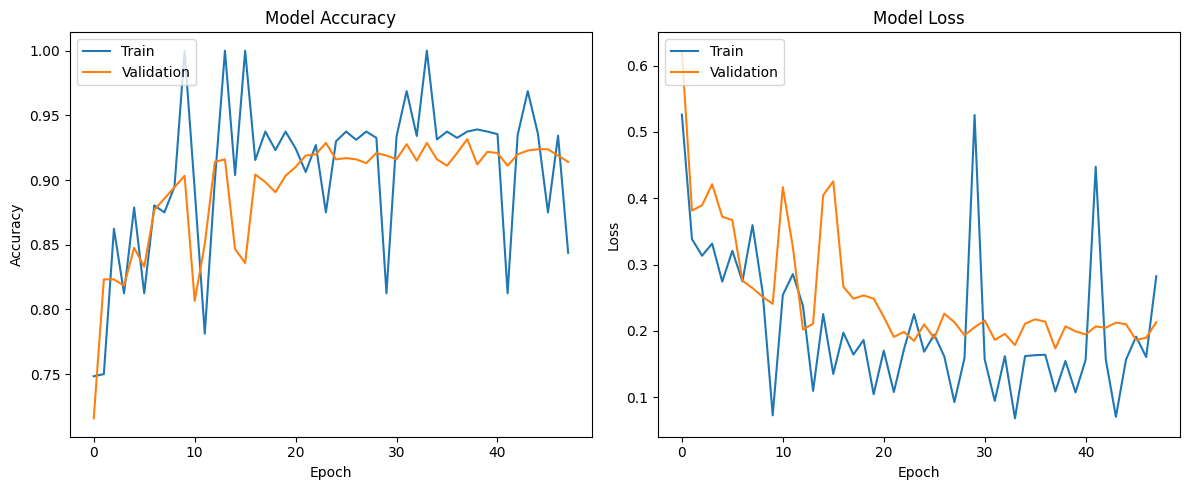

In [253]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plot_path = os.path.join('COMPUTER-VISION', 'training_history.png')
plt.savefig(plot_path)
print(f"Training history plot saved to {plot_path}")
plt.show()

### Prediction step

In [254]:
pred_probs = model.predict(test_generator)
preds = (pred_probs > 0.5).astype(int).flatten()
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(classification_report(true_labels, preds, target_names=class_labels))
print(confusion_matrix(true_labels, preds))

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step
              precision    recall  f1-score   support

      NORMAL       0.91      0.85      0.88       234
   PNEUMONIA       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624

[[199  35]
 [ 20 370]]


In [255]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.9119 - loss: 0.2536
Final Test Accuracy: 91.19%


In [4]:
import os
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load your saved model file
model = load_model('COMPUTER-VISION/pneumonia_model.keras') # Ensure the filename is correct

# 1. Update this path to your actual 'test' folder
test_dir = 'data/chest_xray/test' 

# 2. Setup the generator (just for the test data)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Required for correct AUC calculation
)

# 3. Get probability predictions
# This uses the 'model' variable already in your notebook memory
y_probs = model.predict(test_generator)

# 4. Get ground truth and calculate score
y_true = test_generator.classes
auc_score = roc_auc_score(y_true, y_probs)

print(f"Calculation Complete!")
print(f"ROC AUC Score: {auc_score:.4f}")

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step
Calculation Complete!
ROC AUC Score: 0.9606
